In [1]:
#| output: false

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import plasticnet as pn
import process_images_hdf5 as pi5
from deficit_defs import patch_treatment
from input_environment_defs import get_input_patch_examples
from matplotlib.pyplot import figure,xlabel,ylabel,legend,gca,plot,subplot,imshow,axis

Splikes version  0.1.2
Plasticnet version  0.1.6
macOS-10.16-x86_64-i386-64bit
Base Image File: asdf/bbsk081604_all_log2dog.asdf


## Models of Treatments for Amblyopia {#sec-models-of-treatments}

To model the fix to the refractive imbalance we follow the deficit simulation with an input environment that is rebalanced, both eyes receiving nearly identical input patches (@fig-normal-inputs).   This process is a model of the application of refractive correction.  Although both eyes receive nearly identical input patches, we add independent Gaussian noise to each input channel to represent the natural variation in the activity in each eye.  In addition, in those cases where use employ strabismic amblyopia, the inter-eye jitter is not corrected with the refractive correction.  


In [2]:
#| output: false

def inputs_to_images1(X,buffer=5):
    ims=[]
    
    rf_size=int(np.sqrt(X.shape[1]/2))
    vmax=np.concatenate([xx[:rf_size*rf_size] for xx in X]).max()
    
    for xx in X:
        xx1=xx[:rf_size*rf_size].reshape(rf_size,rf_size)
        im=xx1
        ims.append(im)
        
    return ims

def inputs_to_images2(X,buffer=5):
    ims=[]
    
    rf_size=int(np.sqrt(X.shape[1]/2))
    vmax=np.concatenate([xx[rf_size*rf_size:] for xx in X]).max()
    
    for xx in X:
        xx2=xx[rf_size*rf_size:].reshape(rf_size,rf_size)
        im=xx2
        ims.append(im)
        
    return ims

def inputs_to_images(X,buffer=5):
    ims=[]
    vmin=X.min()
    vmax=X.max()
    
    rf_size=int(np.sqrt(X.shape[1]/2))
        
    for xx in X:
        xx1=xx[:rf_size*rf_size].reshape(rf_size,rf_size)
        xx2=xx[rf_size*rf_size:].reshape(rf_size,rf_size)
        im=np.concatenate((xx1,np.ones((rf_size,buffer))*vmax,xx2),axis=1)   
        ims.append(im)
        
    return ims

def get_input_patch_examples_treatment():
    
    seq=pn.Sequence()    
    seq+=patch_treatment(patch_noise=0.5,
               total_time=1000,number_of_neurons=1,
               eta=1e-6,
               save_interval=1)
    sim=seq.sims[0]
    pre=seq[0][1][0]
    sim.monitor(pre,['output'],1)

    seq.run(display_hash=False,print_time=False)
    m=sim.monitors['output_1']
    t,X=m.arrays()    
    
    return seq,X



## Patch treatment

The typical patch treatment is done by depriving the strong-eye of input with an eye-patch.  In the model this is equivalent to presenting the strong-eye with random noise instead of the natural image input.  Competition between the left- and right-channels drives the recovery, and is produced from the difference between *structured* input into the weak-eye and the *unstructured* (i.e. noise) input into the strong eye.  It is not driven by a reduction in input activity.  @fig-patch-inputs shows sample simulation input patterns from the patched eye.  Compare this to @fig-normal-inputs to see that the simulated patch has far less structure than the normal inputs.


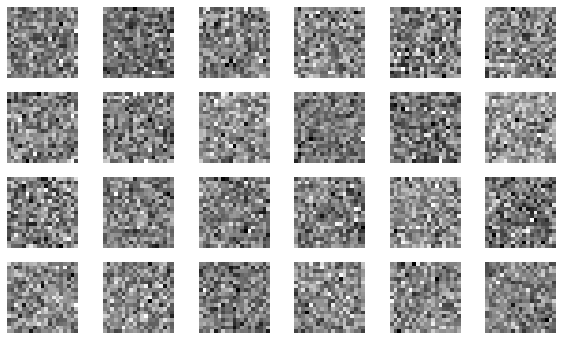

In [3]:
#| echo: false
#| label: fig-patch-inputs
#| fig-cap: A sample of 24 input patches from a patched visual environment. 
#| 
sim,X=get_input_patch_examples_treatment()
ims=inputs_to_images2(X)
figure(figsize=(10,6))
for i in range(24):
    im=ims[i]
    subplot(4,6,i+1)
    imshow(im,cmap=plt.cm.gray)
    axis('off')
    




## Contrast modification

A binocular approach to treatment can be produced with contrast reduction of the non-deprived channel relative to the deprived channel. Experimentally this can be accomplished with VR headsets[@xiao2020improved]. In the model we implement this by down-scaling the normal, unblurred channel with a simple scalar multiplier applied to each pixel (Figure [4](#fig:input) D). The contrast difference sets up competition between the two channels with the advantage given to the weak-eye channel.


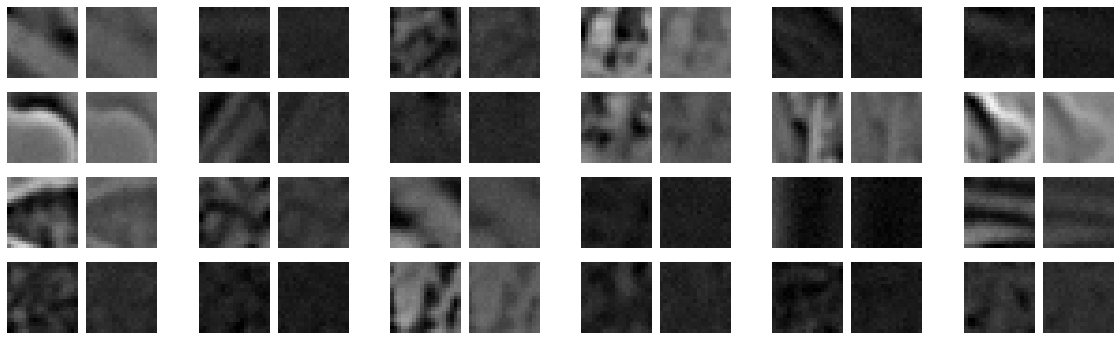

In [6]:
#| label: fig-contrast-modified-inputs
#| fig-cap: A sample of 24 input patches from a normal visual environment with the right-channel down-scaled relative to the left.
#| 
sim,X=get_input_patch_examples(blur=-1,contrast=0.3)
ims=inputs_to_images(X,buffer=2)
figure(figsize=(20,6))
for i in range(24):
    im=ims[i]
    subplot(4,6,i+1)
    imshow(im,cmap=plt.cm.gray)
    axis('off')
    

## Dichoptic Mask

On top of the contrast modification, we can include the application of the dichoptic mask (Figure @fig:input E).  In this method, each eye receives a version of the input images filtered through independent masks in each channel, resulting in a mostly-independent pattern in each channel.  
It has been observed that contrast modification combined with dichoptic masks can be an effective treatment for amblyopia[@Li:2015aa,@xiao2021randomized].  The motivation behind the application of the mask filter is that the neural system must use both channels to reconstruct the full image and thus may lead to enhanced recovery.  

The dichoptic masks are constructed with the following procedure.  A blank image (i.e. all zeros) is made to which is added 15 randomly sized circles with values equal to 1 (Figure @fig:dichopic_blob).   These images are then smoothed with a Gaussian filter of a given width, $f$.  This width is a parameter we can vary to change the overlap between the left- and right-eye images.  A high value of $f$ compared with the size of the receptive field, e.g. $f=90$, yields a high overlap between the patterns in the weak- and strong-eye inputs (Figure @fig:dichopic_filter_size).  Likewise, a small value of $f$, e.g. $f=10$, the eye inputs are nearly independent -- the patterned activity falling mostly on one of the eyes and not much to both.  Finally, the smoothed images are scaled to have values from a minimum of 0 to a maximum of 1.  This image-mask we will call $A$, and is the left-eye mask whereas the right-eye mask, $F$, is the inverse of the left-eye mask, $F\equiv 1-A$.  The mask is applied to an image by multiplying the left- and right-eye images by the left- and right-eye masks, respectively, resulting in a pair of images which have no overlap at the peaks of each mask, and nearly equal overlap in the areas of the images where the masks are near 0.5 (Figure @fig:dichopic_filter_image).   




## Atropine treatment

In the atropine treatment for amblyopia[@glaser2002randomized], eye-drops of atropine are applied to the strong-eye resulting in blurred vision in that eye.  Here we use the same blurred filter used to obtain the deficit (possibly with a different width) applied to the strong eye (Figure @fig:input F).  The difference in sharpness between the strong-eye inputs and the weak-eye inputs sets up competition between the two channels with the advantage given to the weak-eye.

